<h1>CS4618: Artificial Intelligence I</h1>
<h1>Ordinary Least Squares Regression</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import add_dummy_feature

import numpy.linalg as npla

<h1>Acknowledgement</h1>
<ul>
    <li>I based 5 of the diagrams on ones to be found in A. G&eacute;ron: <i>Hands-On Machine Learning 
        with Scikit-Learn &amp; TensorFlow</i>, O'Reilly, 2017
    </li>
</ul>

<h1>Ordinary Least Squares Regression</h1>
<ul>
    <li>We've been focusing on topics such as Data Preparation and Error Estimation, treating the learning itself
        as a black box
        <ul>
            <li>How does linear regression find the best model?</li>
        </ul>
    </li>
    <li>Recap:
        <ul>
            <li>The learner is given a labeled training set ($m \times n$ maxtrix $\v{X}$ and 
                $m$-dimensional vector $\v{y}$) and it inserts an extra element $\v{x}_0^{(i)}$ in each
                row $i$, all of which will be 1
                $$\v{X} = \begin{bmatrix}
                    \v{x}_0^{(1)} = 1 & \v{x}_1^{(1)} & \v{x}_2^{(1)} & \ldots & \v{x}_n^{(1)} \\
                    \v{x}_0^{(2)} = 1 & \v{x}_1^{(2)} & \v{x}_2^{(2)} & \ldots & \v{x}_n^{(2)} \\
                    \vdots            & \vdots        & \vdots        & \vdots & \vdots \\
                    \v{x}_0^{(m)} = 1 & \v{x}_1^{(m)} & \v{x}_2^{(m)} & \ldots & \v{x}_n^{(m)} \\
                          \end{bmatrix}\,\,\,\
                   \v{y} = \cv{y^{(1)}\\ y^{(2)}\\ \vdots\\ y^{(m)}}
                 $$
             </li>
             <li>An $n$-dimensional column vector 
                 $\v{\beta} = \cv{\v{\beta}_0\\ \v{\beta}_1\\ \vdots\\ \v{\beta}_n}$
                 gives us a hypothesis $h_{\v{\beta}}$ where
                 $$\hat{y} = h_{\v{\beta}}(\v{x}) = \v{x}\v{\beta}$$
             <li>It must find the vector $\v{\beta}$
                 that minimizes the following loss function
                 $$J(\v{X}, \v{y}, h_{\v{\beta}}) = \frac{1}{2m}\sum_{i=1}^m(h_{\v{\beta}}(\v{x}^{i)}) - \v{y}^{(i)})^2$$
             </li>
             <li>In Machine Learning, the variabes whose values we are trying to find (in this case, $\v{\beta}$)
                are called the <b>parameters</b>
             </li>
         </ul>
     </li>
</ul>

In [7]:
# Loss function for OLS regression (assumes X contains all 1s in its first column)
def J(X, y, beta):
    return np.mean((X.dot(beta) - y) ** 2) / 2.0

<h2>2D Visualization of $J$</h2>
<ul>
    <li>Let's visualize $J$ using the Cork Property Prices Dataset as the training set
    <li>For a 2D visualization, we'll assume that $\v{\beta}_j = 0$ for all $j$ except $j = 1$
        <ul>
            <li>In other words, we are pretending that floor area is the only relevant feature
            </li>
        </ul>
        Then we can plot $J$ on the vertical axis against different values of
        $\v{\beta}_{1}$ on the horizontal axis
    </li>
</ul>

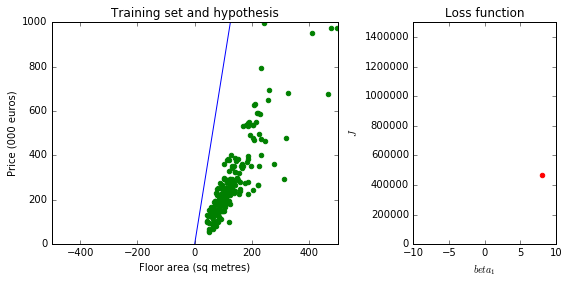

In [8]:
# Use pandas to read the CSV file
df = pd.read_csv("datasets/dataset_corkA.csv")

# Get the feature-values and the target values into separate numpy arrays of numbers
X = df[["flarea"]].values
y = df["price"].values

# Set up the two subplots
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
# Lefthand diagram
ax0 = plt.subplot(gs[0])
plt.title("Training set and hypothesis")
plt.xlabel("Floor area (sq metres)")
plt.xlim(-500, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
# Righthand diagram
ax1 = plt.subplot(gs[1])
plt.title("Loss function")
plt.xlabel("$\v{\beta}_1$")
plt.xlim(-10, 10)
plt.ylabel("$J$")
plt.ylim(0, 1500000)
fig.tight_layout()

# Hypothesis (which assumes beta_i = 0 for all i except i = 1)
def h(x, beta1):
    return x * beta1

# Here's the statement you should vary: try different values of beta1
# To see anything on these axes, try beta1 between -10 and +10
beta1 = 8

# Scatter plot of the training set (lefthand diagram)
ax0.scatter(X, y, color = "green")

# Straight line plot of the hypothesis for this value of beta1 (lefthand diagram)
xvals = np.linspace(-500, 500, 3)
ax0.plot(xvals, h(xvals, beta1), color = "blue")

# Show the value of the loss function for this value of beta1 (righthand diagram)
ax1.scatter(beta1, J(X, y, beta1), color = "red")
plt.show()

<h2>Another 2D Visualization of $J$</h2>
<ul>
    <li>Instead of making manual adjustments, let's use a loop to try several values for $\v{\beta}_1$</li>
</ul>

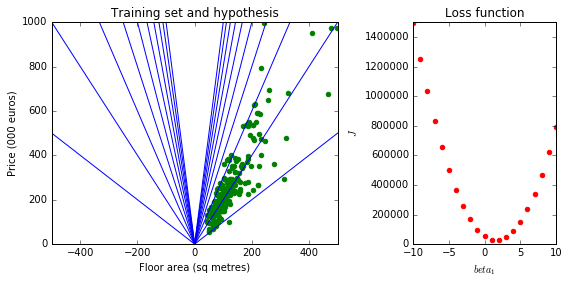

In [9]:
# Set up the two subplots
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
# Lefthand diagram
ax0 = plt.subplot(gs[0])
plt.title("Training set and hypothesis")
plt.xlabel("Floor area (sq metres)")
plt.xlim(-500, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
# Righthand diagram
ax1 = plt.subplot(gs[1])
plt.title("Loss function")
plt.xlabel("$\v{\beta}_1$")
plt.xlim(-10, 10)
plt.ylabel("$J$")
plt.ylim(0, 1500000)
fig.tight_layout()

# Different values of beta1
beta1s = np.linspace(-10, 10, 21)

# Scatter plot of the training set (lefthand diagram)
ax0.scatter(X, y, color = "green")

# Straight line plot of the hypothesis for this value of beta1 (lefthand diagram)
xvals = np.linspace(-500, 500, 3)
for beta1 in beta1s:
    ax0.plot(xvals, h(xvals, beta1), color = "blue")

# Show the value of the loss function for this value of beta1 (righthand diagram)
ax1.scatter(beta1s, [J(X, y, beta1) for beta1 in beta1s], color = "red")
plt.show()

<ul>
    <li>The loss function is <b>convex</b></li>
    <li>Informally, this means:
        <ul>
            <li>
                in 2D, it is u-shaped
            </li>
            <li>
                it has a unique minimum
            </li>
        </ul>
    </li>
    <li>This is no accident: it follows from the way the loss function has been defined</li>
</ul>

<h2>3D Visualization of $J$</h2>
<ul>
    <li>Let's visualize $J$ again using the Cork Property Prices Dataset as the training set</li>
    <li>This time, we'll assume that $\v{\beta}_j = 0$ for all $j$ except $j = 2$ and $j = 3$
        <ul>
            <li>In other words, we are pretending that the number of bedrooms and bathrooms are the only relevant 
               features
            </li>
        </ul>
        This will be a 3D plot with $J$ on the vertical axis against different values of $\v{\beta}_2$ 
        and $\v{\beta}_3$ on the horizontal axes
    </li>
</ul>

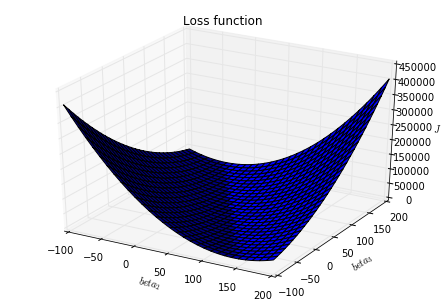

In [10]:
# Get the feature-values and the target values into separate numpy arrays of numbers
X = df[["bdrms", "bthrms"]].values
y = df["price"].values 

fig = plt.figure() 
ax = Axes3D(fig)
ax.set_title("Loss function")
ax.set_xlabel("$\v{\beta}_2$")
ax.set_ylabel("$\v{\beta}_3$")
ax.set_zlabel("$J$")
xvals = np.linspace(-100, 200, 301)
yvals = np.linspace(-100, 200, 301)
xxvals, yyvals = np.meshgrid(xvals, yvals)
zs = np.array([J(X, y, [beta2, beta3]) for beta2, beta3 in zip(xxvals.flatten(), yyvals.flatten())])
zvals = zs.reshape(xxvals.shape)
ax.plot_surface(xxvals, yyvals, zvals)
plt.show()

<h2>Another Visualization of $J$</h2>
<ul>
    <li>Here is the same data that we had in 3D but on a different kind of plot, called a <b>contour plot</b></li>
    <li>In effect, it flattens the diagram above</li>
    <li>The lines connect points that have the same value for $J$</li>
</ul>

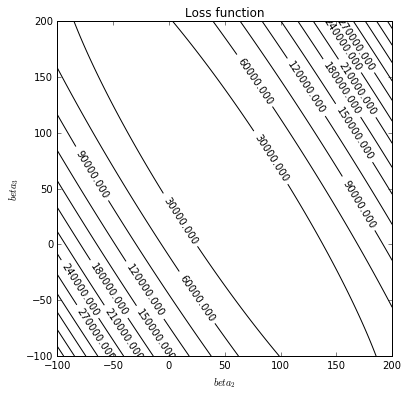

In [11]:
fig = plt.figure(figsize = (6, 6)) 
plt.title("Loss function")
plt.xlabel("$\v{\beta}_2$")
plt.ylabel("$\v{\beta}_3$")
xvals = np.linspace(-100, 200, 301)
yvals = np.linspace(-100, 200, 301)
xxvals, yyvals = np.meshgrid(xvals, yvals)
zs = np.array([J(X, y, [beta2, beta3]) for beta2, beta3 in zip(xxvals.flatten(), yyvals.flatten())])
zvals = zs.reshape(xxvals.shape)
C = plt.contour(xxvals, yyvals, zvals, 15, colors = "black", linewidth = 0.5)
plt.clabel(C, inline=1, fontsize=10)
plt.show()

<ul>
    <li>The 3D visualization and the contour plot show that this too is convex</li>
    <li>Informally, this means:
        <ul>
            <li>
                in 3D it is bowl-shaped
            </li>
            <li>
                again there is a unique minimum
            </li>
        </ul>
    </li>
</ul>

<h1>Ordinary Least Squares Linear Regression</h1>
<ul>
    <li>How to find the best values for $\v{\beta}$</li>
    <li>Two methods:
        <ul>
            <li>The Normal Equation</li>
            <li>Gradient Descent</li>
        </ul>
    </li>
</ul>

<h1>The Normal Equation</h1>
<ul>
    <li>The <b>normal equation</b> solves for $\v{\beta}$:
        $$\v{\beta} = (\v{X}^T\v{X})^{-1}\v{X}^T\v{y}$$
        <ul>
            <li>In other words, the normal equation gives us the
                parameters that minimize the loss function
            </li>
        </ul>
    </li>
    <li>Where does it come from?
        <ul>
            <li>Take the gradient of the loss function: $\frac{1}{m}\v{X}^T(\v{X}\v{\beta} - \v{y})$</li>
            <li>Set it to zero: $\frac{1}{m}\v{X}^T(\v{X}\v{\beta} - \v{y}) = 0$ (in fact, a
                $(n+1)$-dimensional vector of zeros)
            </li>
            <li>Then do some algebraic manipulation to get $\v{\beta}$ on the left-hand side:
                $\v{\beta} = (\v{X}^T\v{X})^{-1}\v{X}^T\v{y}$
            </li>
        </ul>
    </li>
</ul>

<h1>The Normal Equation in scikit-learn</h1>
<ul>
    <li>The <code>fit</code> method of scikit-learn's <code>LinearRegression</code> class does
        what we have described:
        <ul>
            <li>It inserts the extra column of 1s</li>
            <li>It calculates $\v{\beta}$ using the normal equation</li>
        </ul>
    </li>
</ul>

<h1>The Normal Equation in numpy</h1>
<ul>
    <li>For the hell of it, let's see how to implement it ourselves</li>
    <li>(We'll be naughty: we'll train on the whole dataset)</li>
</ul>

In [12]:
# Use pandas to read the CSV file
df = pd.read_csv("datasets/dataset_corkA.csv")

# Get the feature-values and the target values 
X_without_dummy = df[["flarea", "bdrms", "bthrms"]].values
y = df["price"].values

# Add the extra column to X
X = add_dummy_feature(X_without_dummy)

# Solve the normal equation
beta = npla.inv(X.T.dot(X)).dot(X.T).dot(y)

# Display beta
beta

array([ 3.04842995,  1.9103426 ,  8.27623284, -0.69107087])

<ul>
    <li>Essentially, one line of code!</li>
    <li>But there's a problem:
        <ul>
            <li>The normal equation requires that $\v{X}^T\v{X}$ has an inverse</li>
            <li>But it might not (see earlier lecture about matrices)</li>
        </ul>
        When we discussed this before, we mentioned that, in some cases, we can use the 
        <em>pseudo-inverse</em> instead
        <ul>
            <li>This is one of those cases</li>
        </ul>
    </li>
    <li>So the more robust way of writing this program is:
</ul>

In [13]:
# Solve the normal equation - but using the pseudo-inverse
beta = npla.pinv(X.T.dot(X)).dot(X.T).dot(y)

# Display beta
beta

array([ 3.04842995,  1.9103426 ,  8.27623284, -0.69107087])

<h1>Gradient Descent</h1>
<ul>
    <li><b>Gradient Descent</b> is a generic method for finding optimal solutions to problems that involve
        minimizing a loss function
    </li>
    <li>It is a <em>search</em> in the model's <b>parameter space</b> for values of the parameters that minimize 
        the loss function
    </li>
    <li>Conceptually:
        <ul>
            <li>
                 It starts with an initial guess for the values of the parameters 
            </li>
            <li>
                Then repeatedly:
                <ul>
                    <li>It updates the parameter values  &mdash; hopefully to reduce the loss
                    </li>
                </ul>
            </li>
        </ul>
        <img src="images/21_fog.jpg" />
    </li>
    <li>
        Ideally, it keeps doing this until <b>convergence</b> &mdash; changes to the paramter values do not result
        in lower loss 
    </li>
    <li>The key to this algorithm is how to update the parameter values</li>
</ul>

<h2>Baby steps</h2>
<ul>
    <li>We'll use  an example with a single feature/single parameter $\beta_1$ in order to visualize</li>
    <li>We update $\beta_1$ gradually, one baby step at a time, unitl the algorithm converges on minimum loss
        <figure>
            <img src="images/21_baby_steps1.png" />
        </figure>
    </li>
    <li>The size of the steps is determined by a <b>hyperparameter</b> called the <b>learning rate</b>
        <ul>
            <li>(Hyperparamters are explained in CS4619)</li>
        </ul>
    </li>
    <li>If the learning rate is too small, it will take many updates until convergence:
        <figure>
            <img src="images/21_baby_steps2.png" />
        </figure>
    </li>
    <li>If the learning rate is too big, the algorithm might jump across the valley &mdash; it may even end up with
        higher loss than before, making the next step bigger
        <ul>
            <li>This might make the algorithm <b>diverge</b>
            </li>
        </ul>
        <figure>
            <img src="images/21_baby_steps3.png" />
        </figure>
    </li>
</ul>

<h1>Non-Convex Functions</h1>
<ul>
    <li>The loss function for OLS regression is convex
        <ul>
            <li>a single minimum</li>
        </ul>
        and it has a slope that never changes abruptly
        <ul>
            <li>The algorithm is guaranteed to approach arbitrarily close to the minimum
                (if it runs long enough and if the learning rate isn't too high)
            </li>
        </ul>
    </li>
    <li>But not all loss functions are convex, which can cause problems for Gradient Descent
        <figure>
            <img src="images/21_local_min.png" />
        </figure>
        <ul>
            <li>The algorithm might converge to a local minimum, instead of the global minimum</li>
            <li>It may take a long time to cross a plateau</li>
        </ul>
    </li>
</ul>

<h1>Scaling</h1>
<ul>
    <li>When features have very different ranges of values, we may need to scale (min-max scaling or standardization):
        <ul>
            <li>Whenever we use Euclidean distance, e.g. in a clustering algorithm</li>
            <li>For PCA (although scikit-learn's PCA class will do it for us)</li>
        </ul>
    </li>
    <li>For Gradient Descent, we should also scale the features
    </li>
    <li>We do not need to scale if we are doing OLS regression using the Normal Equation
        <ul>
            <li>It is not 'wrong-footed' by features of different scales</li>
        </ul>
    </li>
</ul>

<h2>Why we need to scale for Gradient Descent</h2>
<ul>
    <li>If features have different ranges, it affects the shape of the 'bowl'</li>
    <li>E.g. features 1 and 2 have similar ranges of values &mdash; a 'bowl'
        <figure>
            <img src="images/21_scaled.png" />
        </figure>
        <ul>
            <li>The algorithm goes straight towards the minimum</li>
        </ul>
    </li>
    <li>E.g. feature 1 has a smaller values than feature 2 &mdash; an elongated 'bowl'
        <figure>
            <img src="images/21_unscaled.png" />
        </figure>
        <ul>
            <li>Since feature 1 has smaller values, it takes a larger change in $\v{\beta}_1$ to affect 
                the loss function, which is why it is elongated
            </li>
            <li>It takes more steps to get to the minimum &mdash; steeply down but not really towards the
                goal, followed by a long march down a nearly flat valley
            </li>
        </ul>
    </li>
</ul>